Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [2]:
# the interactions table should really have the following header (but doesn't currently)
# audit_task_interaction_id, audit_task_id, action, gsv_panorama_id, lat, lng, heading, pitch, zoom, note, 
# timestamp, temporary_label_id, mission_id 

# I had to turn off exceptions because of parsing problems, including:
# https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues/3
# col_names = ['audit_task_interaction_id', 'audit_task_id', 'action', 'gsv_panorama_id', 'lat', 'lng', 
#            'heading', 'pitch', 'zoom', 'note', 'timestamp', 'temporary_label_id', 'mission_id']
# interactions = pd.read_csv('ml-interactions5000.csv', error_bad_lines=False,
#                           header=None, names = col_names, index_col=False) 
#interactions = pd.read_csv('ml-interactions5000.csv')

In [3]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#interactions = pd.read_csv('ml-interactions15000.csv')
#display(df_interactions.head())

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])

print("Printing all rows where 'action' == NaN...")
display(df_interactions[isna_result])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')

# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
print("Printing all rows where 'action' == NaN... there should be no rows")
display(df_interactions[isna_result])


Printing all rows where 'action' == NaN...


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id
18502779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Printing all rows where 'action' == NaN... there should be no rows


,ml-interactions.csv,user_id,audit_task_interaction_id,audit_task_id,action,gsv_panorama_id,lat,lng,heading,pitch,zoom,note,temporary_label_id,mission_id


In [116]:
df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [4]:
assert sum(df_interactions['action'].isna()) == 0

In [27]:
def scatter(series, name, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel('accuracy')
    slope, intercept, r_value, p_value, std_err = stats.linregress(series, users[' accuracy'])
    p = np.poly1d([slope, intercept])
    ax.plot(series, p(series), 'r--')
    ax.scatter(series, users[' accuracy'])

In [6]:
# analyze avg num of mouse moves per pano vs accuracy

In [67]:
user_id_group = df_interactions.groupby('user_id')

In [9]:
keyboard_counts = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])))

In [10]:
users = users.set_index('user_id')

In [11]:
users.head()

,username,labels_validated,role,accuracy
user_id,,,,
0e1ae564-6d72-4670-98e4-71369cc5ab26,AHLS6AZ1VTNH7,472,Turker,74.955595
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51,A1A73A5Z4SDW06,393,Turker,84.551148
49723673-044d-4b47-855b-3bdebfe37073,shaunkuo,518,Registered,82.817869
7b1596af-14d4-4f2b-9e4e-71b1884db836,A1EK8YNHZHTW1J,98,Turker,82.178218
86d26e9d-010f-4802-88ba-680ae0a8e20d,A2AHXGFXPG6ZSR,157,Turker,38.497653


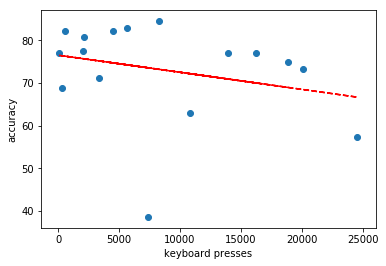

In [12]:
scatter(keyboard_counts, 'keyboard presses')

(array([1., 0., 0., 0., 1., 1., 1., 3., 4., 5.]),
 array([38.49765258, 43.10300215, 47.70835171, 52.31370128, 56.91905084,
        61.5244004 , 66.12974997, 70.73509953, 75.3404491 , 79.94579866,
        84.55114823]),
 <a list of 10 Patch objects>)

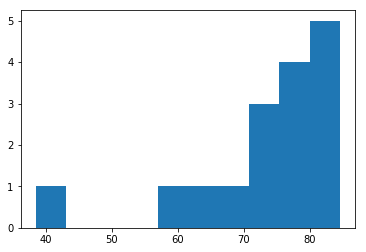

In [13]:
plt.figure()
plt.hist(users[' accuracy'])

In [15]:
num_missions = df_interactions.groupby('user_id').apply(lambda x: sum(x['action']=='MissionComplete'))

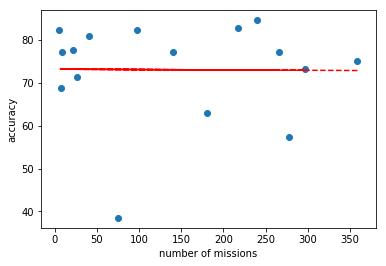

In [16]:
scatter(num_missions, 'number of missions')

Scatter matrix

In [18]:
keyboard_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])) / x['gsv_panorama_id'].unique().size)

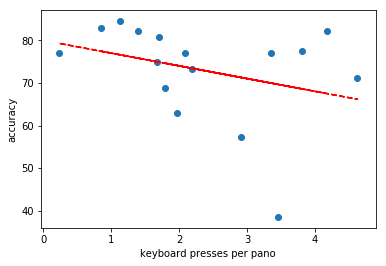

In [19]:
scatter(keyboard_per_pano, 'keyboard presses per pano')

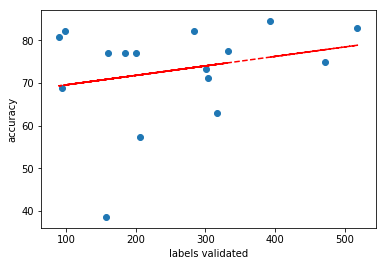

In [20]:
scatter(users[' labels_validated'], 'labels validated')

In [21]:
pov_per_panorama = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].size)



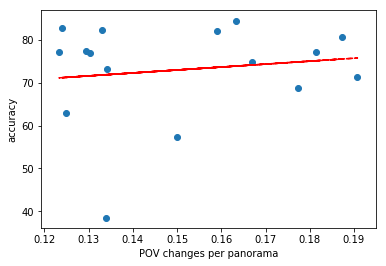

In [22]:
scatter(pov_per_panorama, 'POV changes per panorama')

In [23]:
avg_zoom = df_interactions.groupby('user_id').apply(lambda x: x['zoom'].mean())

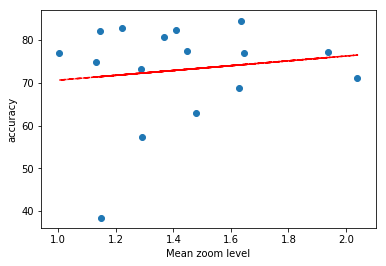

In [24]:
scatter(avg_zoom, 'Mean zoom level')

In [25]:
mouse_moves_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove') / x['gsv_panorama_id'].unique().size)

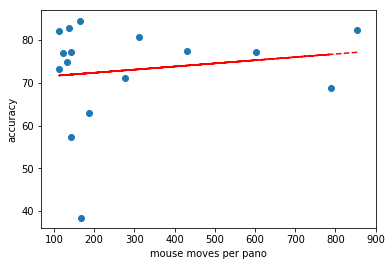

In [28]:
scatter(mouse_moves_per_pano, 'mouse moves per pano')

In [71]:
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)
up_key_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['note'] == 'keyCode:38') / x['gsv_panorama_id'].unique().size)

<IPython.core.display.Javascript object>


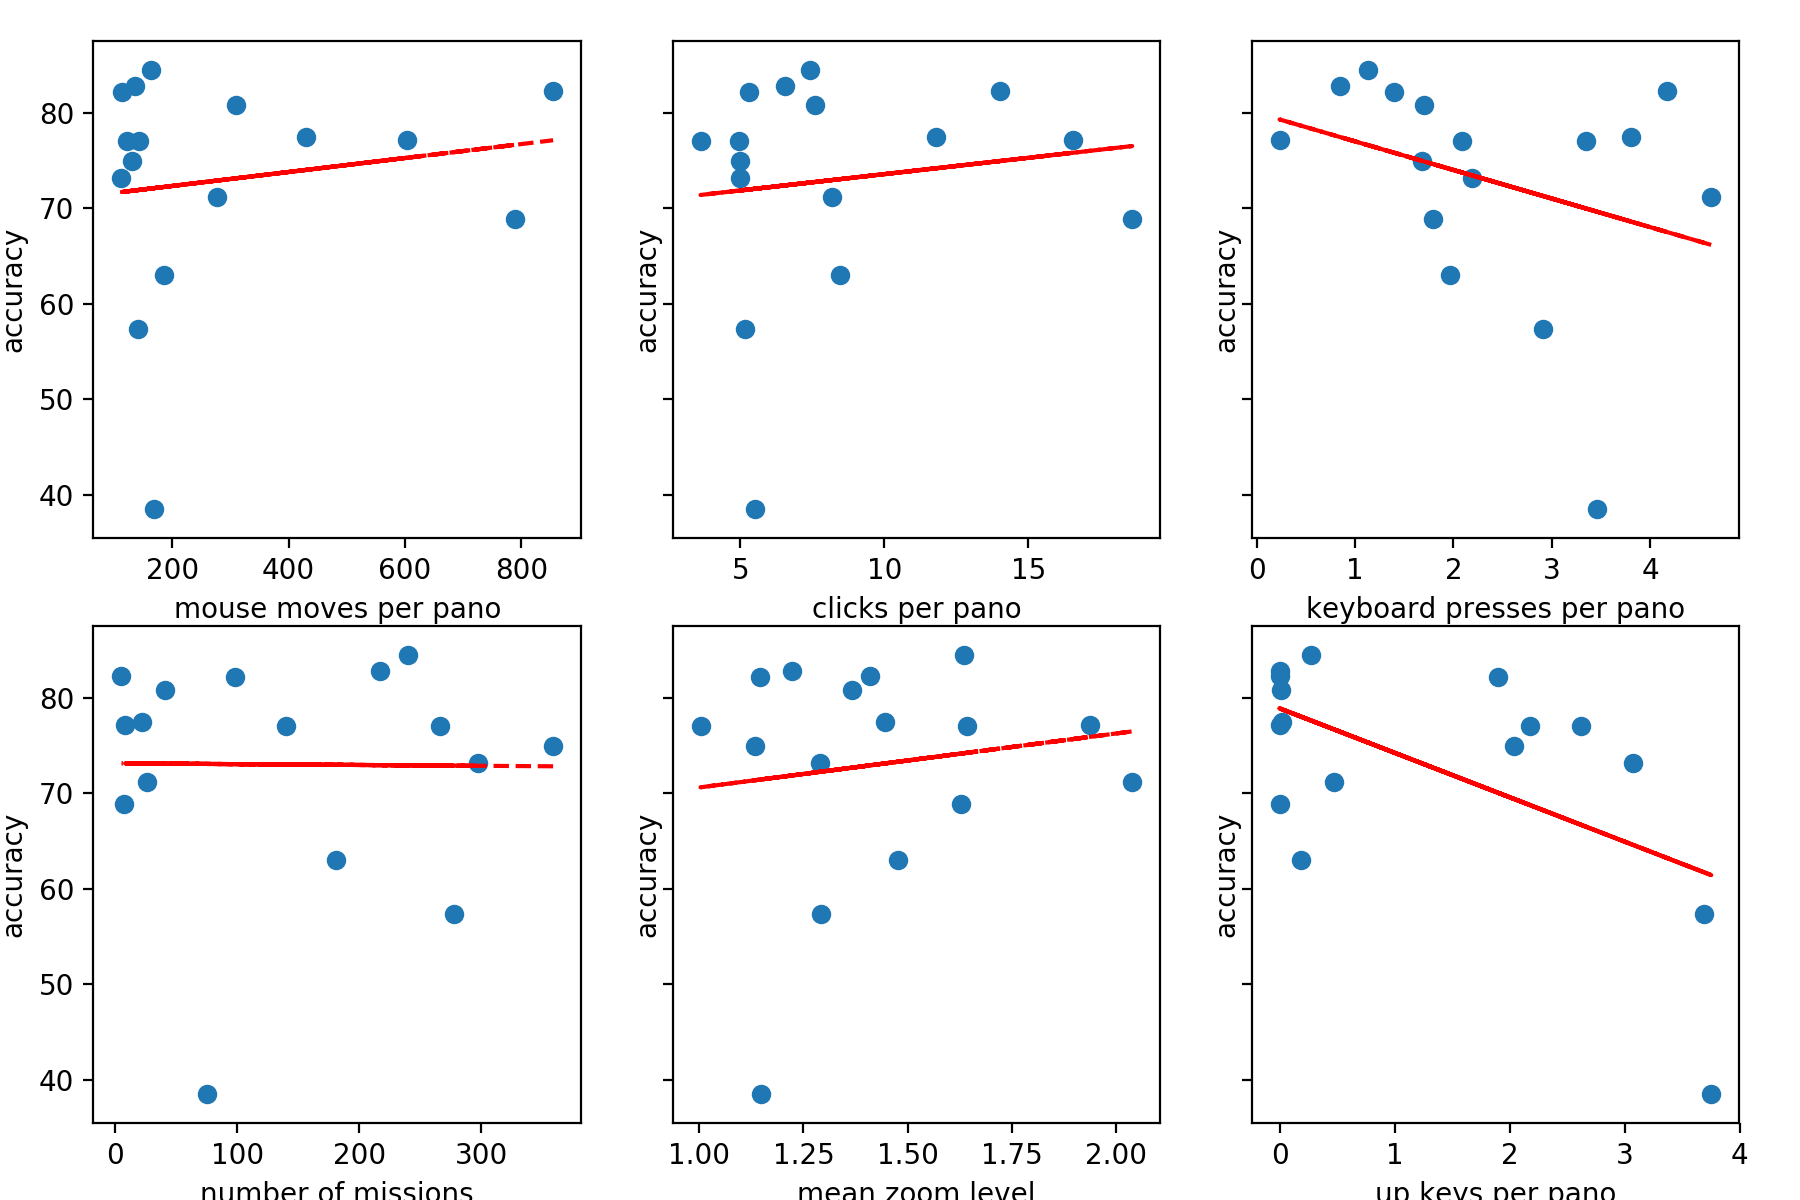

In [72]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, figsize=(9, 6))
fig.tight_layout()
scatter(mouse_moves_per_pano, 'mouse moves per pano', ax=ax[0][0])
scatter(clicks_per_pano, 'clicks per pano', ax=ax[0][1])
scatter(keyboard_per_pano, 'keyboard presses per pano', ax=ax[0][2])
scatter(num_missions, 'number of missions', ax=ax[1][0])
scatter(avg_zoom, 'mean zoom level', ax=ax[1][1])
scatter(up_key_per_pano, 'up keys per pano', ax=ax[1][2])

<IPython.core.display.Javascript object>


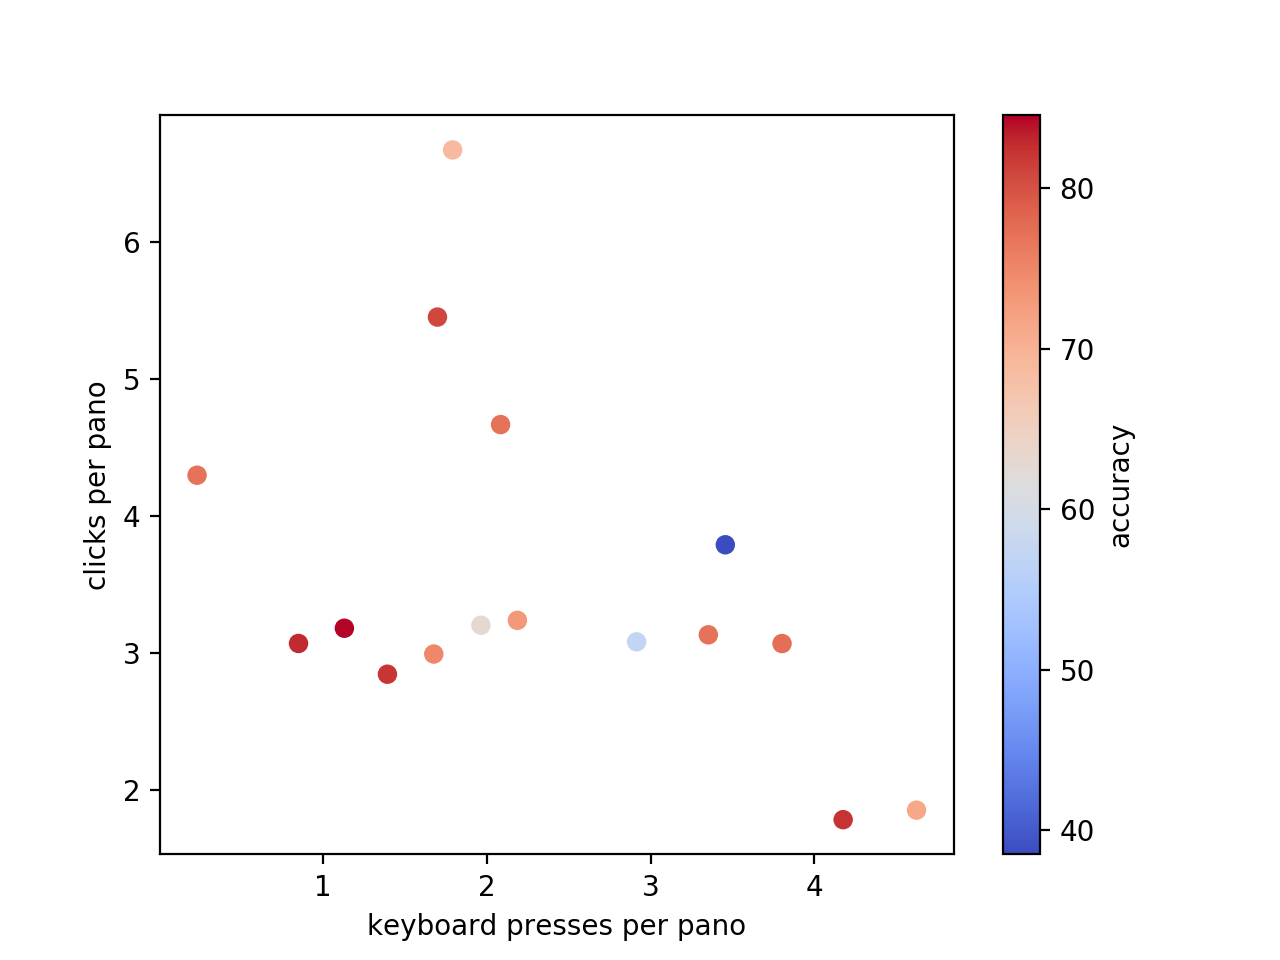

In [244]:
fig, ax = plt.subplots()
ax.set_xlabel('keyboard presses per pano')
ax.set_ylabel('clicks per pano')
sc = ax.scatter(keyboard_per_pano, med_time_pov_label, c=users[' accuracy'], cmap='coolwarm')
cbar = plt.colorbar(sc)
cbar.set_label('accuracy')

### Time between labeling and last POV_Changed 

In [235]:
def median_time_between_pov_change_and_label(u):
    pov_changed = u[u['action']=='POV_Changed']['timestamp'].apply(lambda x: parse(x)).sort_values()
    finish_labeling = u[u['action'] == 'LabelingCanvas_FinishLabeling']['timestamp'].apply(lambda x: parse(x))
    time_sec = np.array([(finish_labeling.iloc[index] - pov_changed.iloc[pov_changed.searchsorted(finish_labeling.iloc[index]) - 1]).total_seconds() for index in range(finish_labeling.size)])
    return np.mean(time_sec)

In [225]:
u = df_interactions[df_interactions['user_id'] == 'e4ff325c-309b-4ea6-8555-8f973e662362']
# u = df_interactions

In [226]:
pov_changed = u[u['action']=='POV_Changed']['timestamp'].apply(lambda x: parse(x))

In [227]:
    finish_labeling = u[u['action'] == 'LabelingCanvas_FinishLabeling']['timestamp'].apply(lambda x: parse(x))

In [228]:
pov_changed = pov_changed.sort_values()

In [229]:
time_sec = np.array([(finish_labeling.iloc[index] - pov_changed.iloc[pov_changed.searchsorted(finish_labeling.iloc[index]) - 1]).total_seconds() for index in range(finish_labeling.size)])
    

In [230]:
# reject outliers
quartile_1, quartile_3 = np.percentile(time_sec, [25, 75])
iqr = quartile_3 - quartile_1
time_sec = time_sec[(time_sec < quartile_3 + (iqr * 1.5)) & (time_sec > quartile_1 - (iqr * 1.5))]

<IPython.core.display.Javascript object>


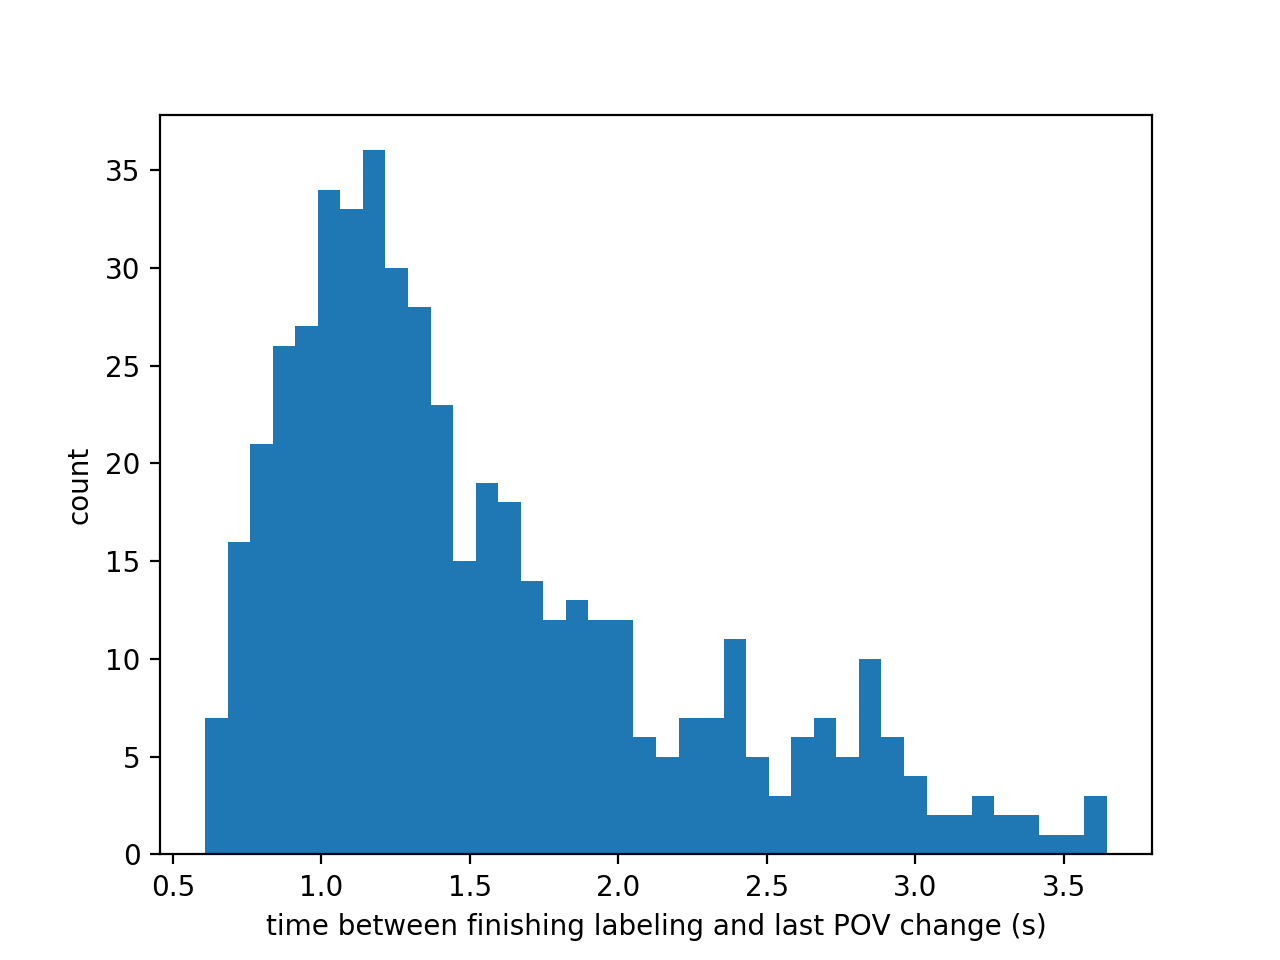

Text(0, 0.5, 'count')

In [231]:
plt.figure()
plt.hist(time_sec, bins=40)
plt.xlabel('time between finishing labeling and last POV change (s)')
plt.ylabel('count')

In [236]:
med_time_pov_label = df_interactions.groupby('user_id').apply(lambda x: median_time_between_pov_change_and_label(x))

<IPython.core.display.Javascript object>


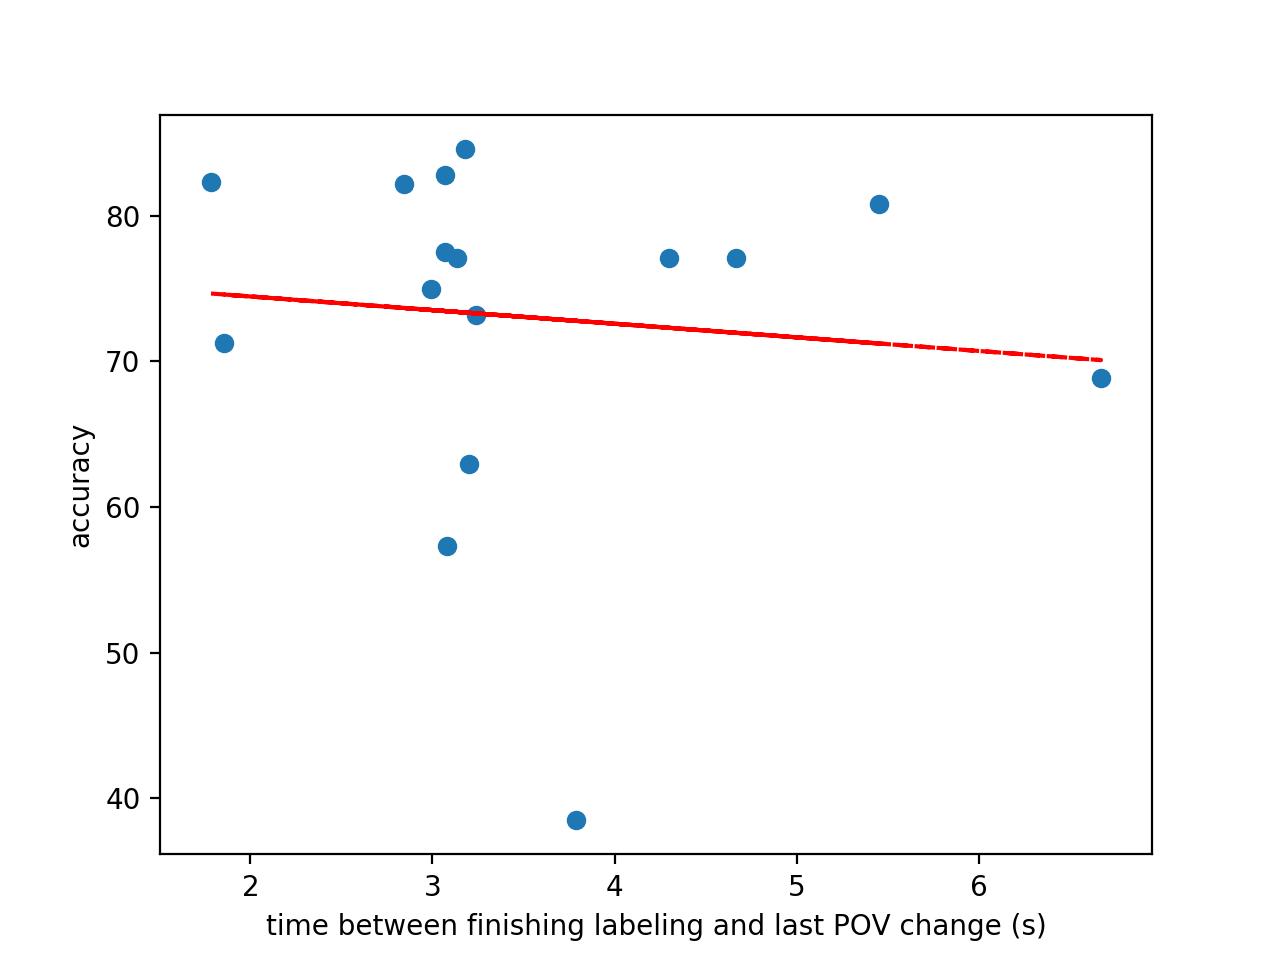

In [238]:
scatter(med_time_pov_label, 'time between finishing labeling and last POV change (s)')

## Amount of pano seen

In [316]:
u = df_interactions[df_interactions['user_id'] == 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'].sort_values('timestamp')

In [364]:
# u.groupby('gsv_panorama_id').apply(lambda x: print(x[x['action'] == 'POV_Changed']['heading'].unique().size))

In [337]:
# k = u[(u['gsv_panorama_id'] == 'yswXpbti65Rk8pcuuB5IAQ') & (u['action'] == 'POV_Changed')]
k = u[(u['gsv_panorama_id'] == np.random.choice(u['gsv_panorama_id'].unique())) & (u['action'] == 'POV_Changed')]

In [338]:
timestamps = k['timestamp'].apply(lambda x: parse(x))
timedeltas = (timestamps - timestamps.iloc[0]).apply(lambda x: x.total_seconds())
headings = k['heading']

In [368]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return pd.Series({'min': np.min(norm), 'max': np.max(norm)})

<IPython.core.display.Javascript object>


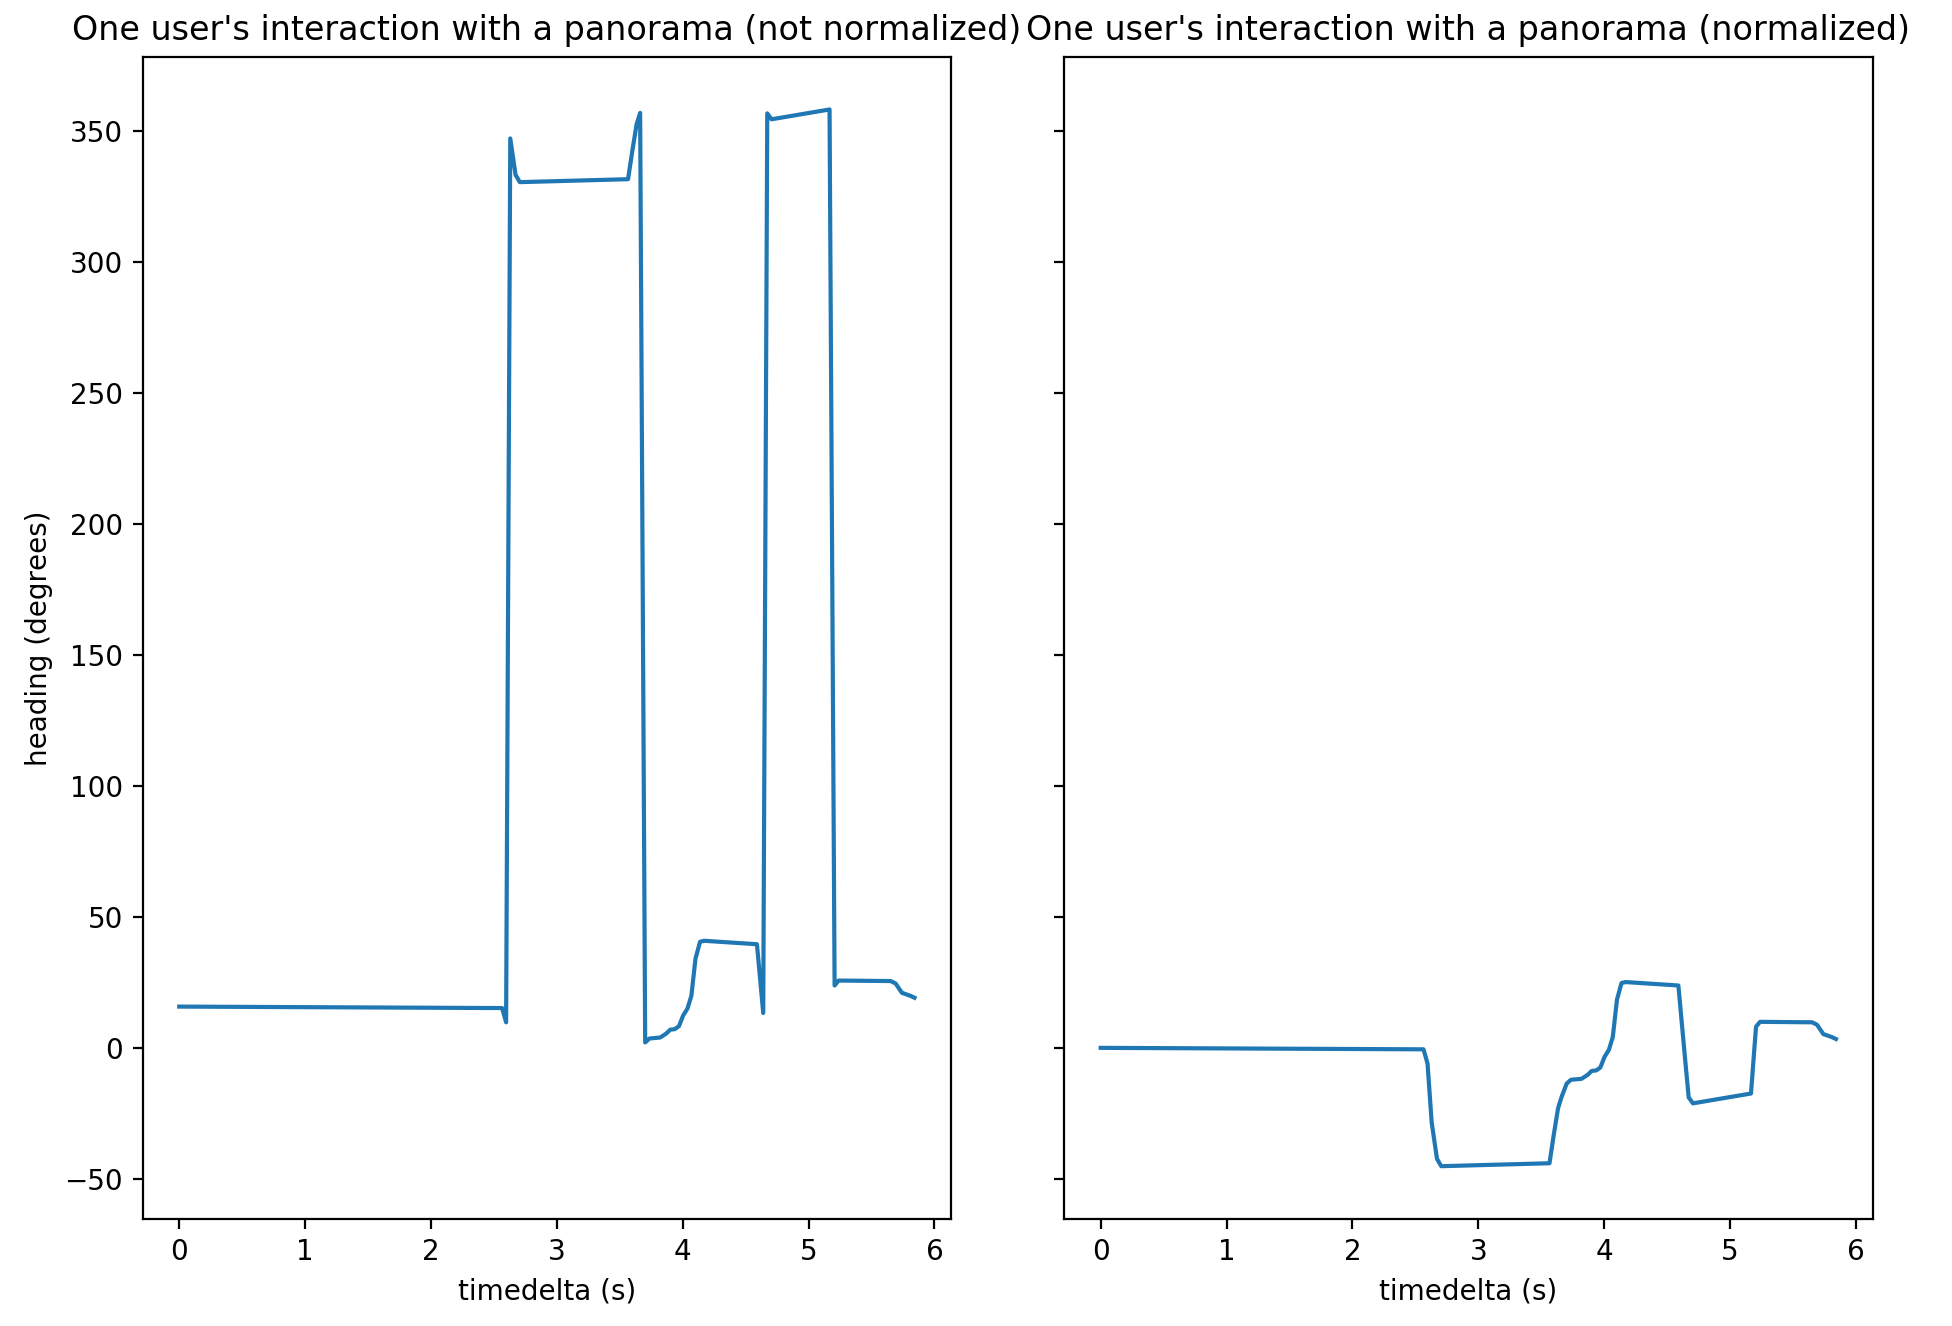

In [363]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.tight_layout()
ax[0].set_title('One user\'s interaction with a panorama (not normalized)')
ax[0].set_ylabel('heading (degrees)')
ax[0].set_xlabel('timedelta (s)')
ax[0].plot(timedeltas, headings, label=k['gsv_panorama_id'].iloc[0])

ax[1].set_title('One user\'s interaction with a panorama (normalized)')
ax[1].set_xlabel('timedelta (s)')
ax[1].plot(timedeltas, normalize_headings(headings), label=k['gsv_panorama_id'].iloc[0])

Let's assume that the range of seen positions is between the min normalized heading and the max normalized heading.

In [369]:
u_pov = u[u['action'] == 'POV_Changed']
seen_range = u_pov.groupby('gsv_panorama_id').apply(lambda x: range_headings(x['heading']))

<IPython.core.display.Javascript object>


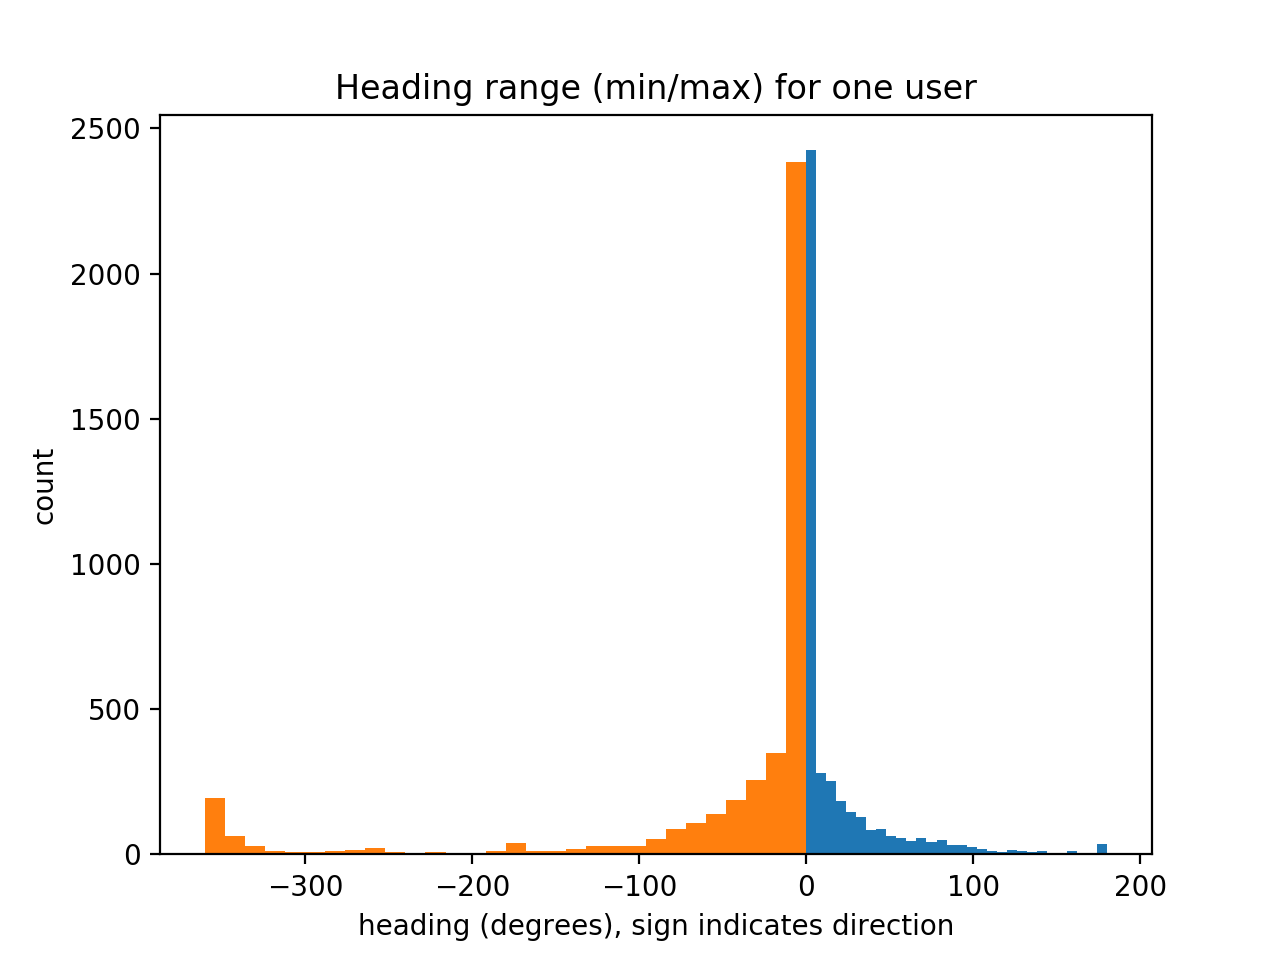

(array([1.940e+02, 6.500e+01, 3.000e+01, 1.200e+01, 8.000e+00, 7.000e+00,
        1.000e+01, 1.600e+01, 2.300e+01, 8.000e+00, 3.000e+00, 8.000e+00,
        6.000e+00, 1.000e+00, 1.300e+01, 4.000e+01, 1.300e+01, 1.300e+01,
        2.000e+01, 3.000e+01, 2.900e+01, 2.900e+01, 5.400e+01, 8.600e+01,
        1.090e+02, 1.390e+02, 1.880e+02, 2.570e+02, 3.500e+02, 2.384e+03]),
 array([-359.82143293, -347.82738517, -335.8333374 , -323.83928964,
        -311.84524187, -299.85119411, -287.85714634, -275.86309858,
        -263.86905081, -251.87500305, -239.88095529, -227.88690752,
        -215.89285976, -203.89881199, -191.90476423, -179.91071646,
        -167.9166687 , -155.92262094, -143.92857317, -131.93452541,
        -119.94047764, -107.94642988,  -95.95238211,  -83.95833435,
         -71.96428659,  -59.97023882,  -47.97619106,  -35.98214329,
         -23.98809553,  -11.99404776,    0.        ]),
 <a list of 30 Patch objects>)

In [393]:
plt.figure()
plt.title('Heading range (min/max) for one user')
plt.xlabel('heading (degrees), sign indicates direction')
plt.ylabel('count')
plt.hist(seen_range['max'], bins=30)
plt.hist(seen_range['min'], bins=30)

<IPython.core.display.Javascript object>


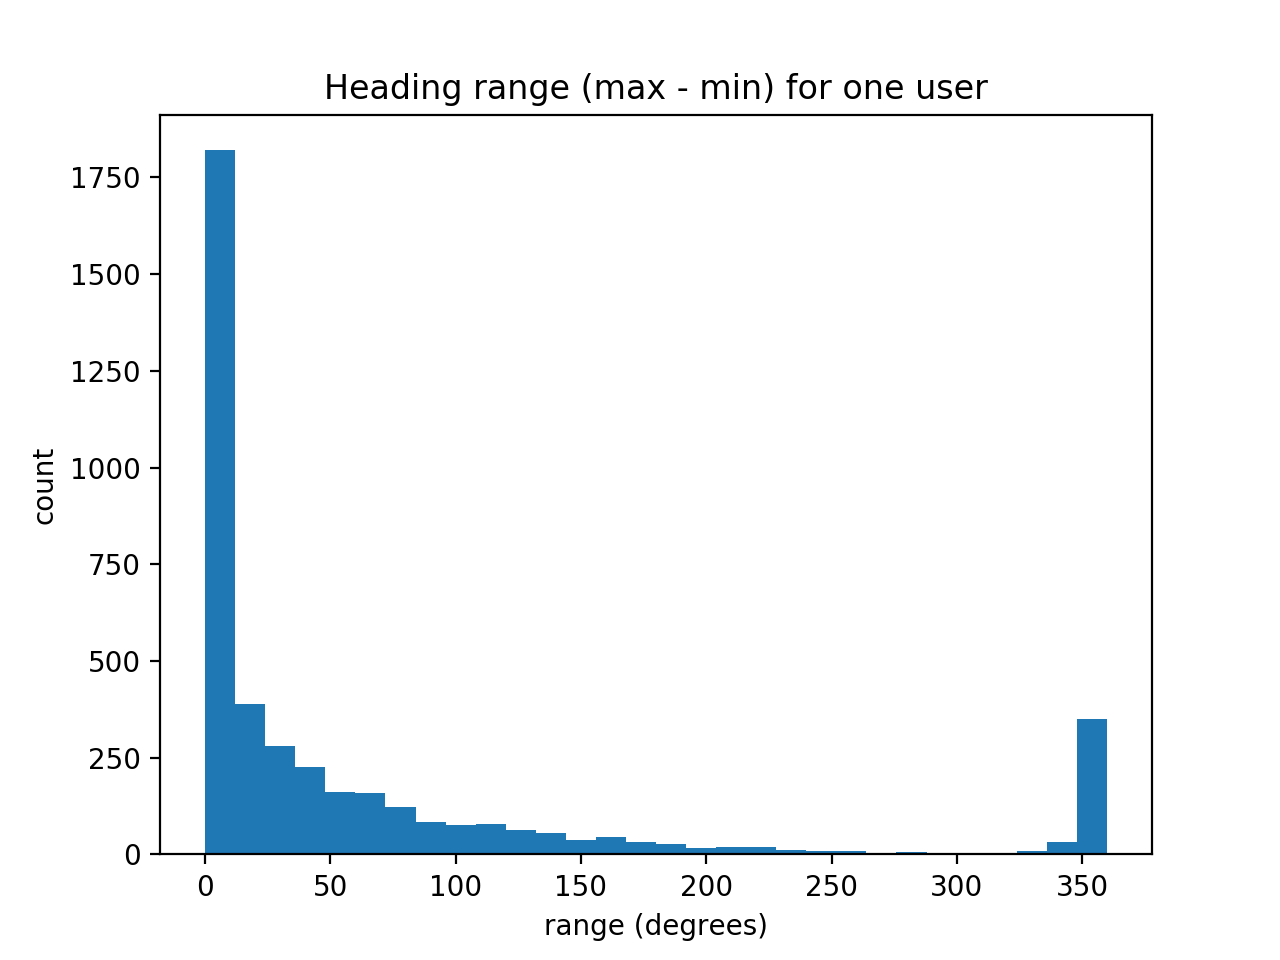

(array([1820.,  389.,  280.,  225.,  161.,  158.,  122.,   85.,   75.,
          78.,   64.,   56.,   37.,   44.,   31.,   27.,   16.,   18.,
          19.,   12.,   10.,   10.,    4.,    6.,    2.,    0.,    4.,
           9.,   32.,  351.]),
 array([  0.        ,  11.99702425,  23.99404849,  35.99107274,
         47.98809698,  59.98512123,  71.98214547,  83.97916972,
         95.97619396, 107.97321821, 119.97024246, 131.9672667 ,
        143.96429095, 155.96131519, 167.95833944, 179.95536368,
        191.95238793, 203.94941217, 215.94643642, 227.94346067,
        239.94048491, 251.93750916, 263.9345334 , 275.93155765,
        287.92858189, 299.92560614, 311.92263038, 323.91965463,
        335.91667888, 347.91370312, 359.91072737]),
 <a list of 30 Patch objects>)

In [397]:
plt.figure()
plt.title('Heading range (max - min) for one user')
plt.xlabel('range (degrees)')
plt.ylabel('count')
plt.hist(seen_range['max'] - seen_range['min'], bins=30)

In [403]:
def get_mean_heading_range(x):
    x_pov = x[x['action'] == 'POV_Changed']
    seen_range = x_pov.groupby('gsv_panorama_id').apply(lambda y: range_headings(y['heading']))
    return np.mean(seen_range['max'] - seen_range['min'])

In [405]:
mean_heading_range = df_interactions.groupby('user_id').apply(lambda x: get_mean_heading_range(x))

<IPython.core.display.Javascript object>


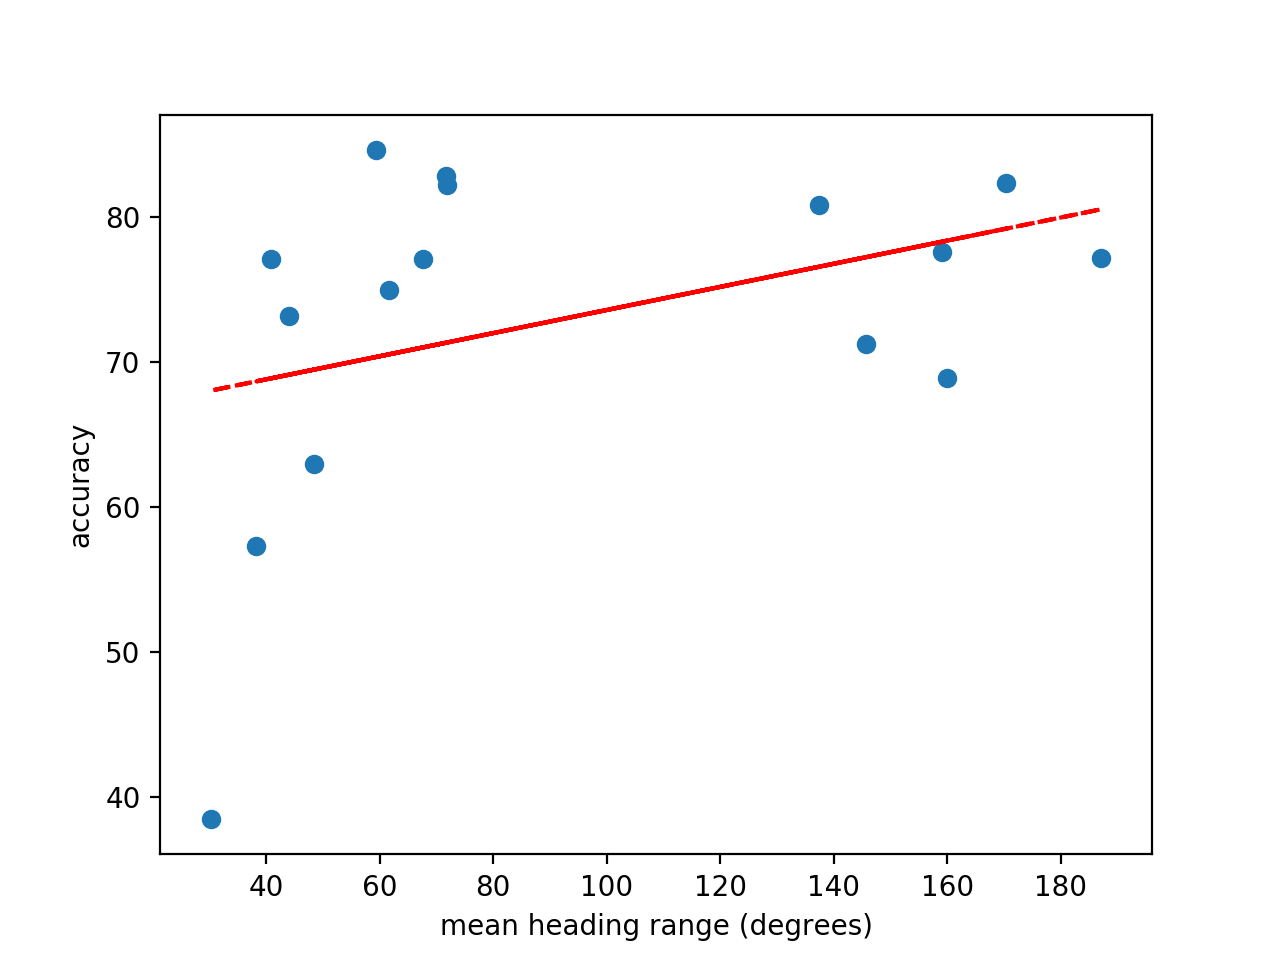

In [406]:
scatter(mean_heading_range, 'mean heading range (degrees)')